In [1]:
import sys
sys.path.append('..')
from scripts.GenrationGI0 import rGI0
import matplotlib.pyplot as plt

In [2]:
g, gi, gI0 = rGI0(n=100*100, p_alpha=-1.5, p_gamma=1, p_Looks=1)

In [3]:
g = g.reshape(100, 100)
gi = gi.reshape(100, 100)
gI0 = gI0.reshape(100, 100)

Text(0.5, 1.0, 'Ruido speckle ~ Gamma')

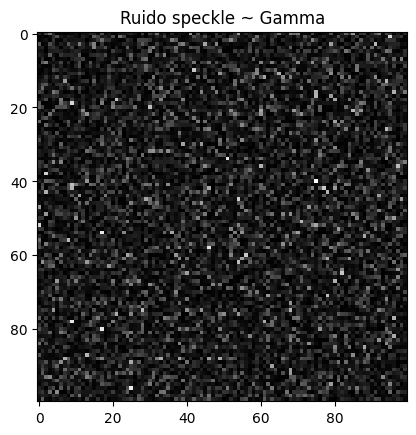

In [4]:
plt.imshow(g, cmap='gray')
plt.title('Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Backscatter ~ Gamma inversa')

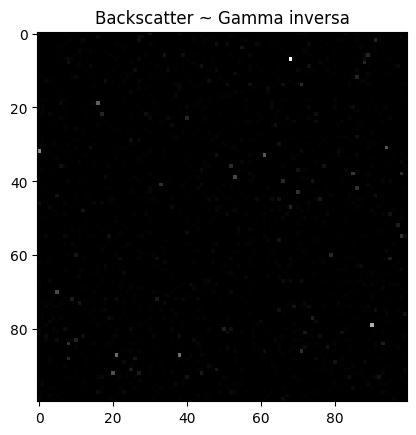

In [5]:
plt.imshow(gi, cmap='gray')
plt.title('Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imágen + ruido speckle ~ GI0')

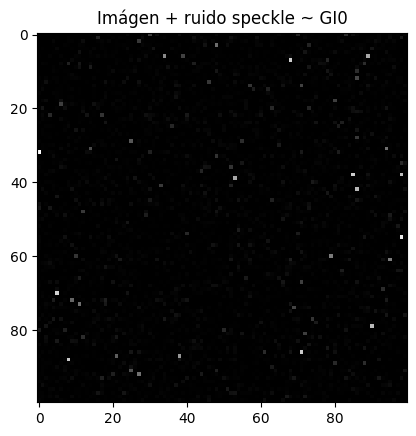

In [6]:
plt.imshow(gI0, cmap='gray')
plt.title('Imágen + ruido speckle ~ GI0')